## Manually Label Project Metaphors

Randomly select projects and extract potential metaphors. Manually label whether the presented text fragment contains a metaphorical cancer-related phrase. Focus given to the underlined keyword token.

In [3]:
import os.path as op

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

import pandas as pd
from sklearn.metrics import precision_score, recall_score

import re

In [4]:
DATA_PROCESSED = '../data/processed'

UNDERLINE = '\033[4m'
END = '\033[0m'

### Load Projects and Labeled Keywords

In [8]:
all_projects = pd.read_csv(op.join(DATA_PROCESSED, 'combined_projects.csv'))

In [9]:
all_projects.shape

(2041, 48)

In [10]:
labeled = pd.read_csv(op.join(DATA_PROCESSED, 'labeled.csv'))

### Confidence levels

In [87]:
ixs = all_projects.loc[all_projects['source'] == 'gofundme', 'id'].values
filt = labeled.loc[labeled['project_id'].isin(ixs), 'metaphorical'].dropna()
p_hat = filt.mean()
n = len(filt)
del ixs, filt

z005 = 2.575829

print(f'Sample proportion of metaphorical keywords:\t {p_hat*100:.2f}%')
print(f'99% CI:\t ({(p_hat - z005 * np.sqrt(p_hat * (1-p_hat) / n)) * 100:.2f}%, {(p_hat + z005 * np.sqrt(p_hat * (1-p_hat) / n)) * 100:.2f}%)')
print(f'For {p_hat*100:.2f}% +- 1%:\t n > {int(z005**2 * p_hat * (1-p_hat) / 0.01**2):,}')
print(f'For {p_hat*100:.2f}% +- 0.5%:\t n > {int(z005**2 * p_hat * (1-p_hat) / 0.005**2):,}')

Sample proportion of metaphorical keywords:	 84.34%
99% CI:	 (80.61%, 88.06%)
For 84.34% +- 1%:	 n > 8,765
For 84.34% +- 0.5%:	 n > 35,060


In [11]:
# these are ordered lists - since we search in order the lemma comes last (so not to catch non-lemma'd words)

BATTLE_WORDS = ['fights', 'fighting', 'fight', 'fought', 'battles', 'battled', 'battling', 'battle', 'war', 'beating', 'beats', 'beaten', 'beat', 'enemy', 'brutal', 'defeat', 'winning', 'win']

JOURNEY_WORDS = ['path', 'journey', 'destination']

window = 80

# Manually Label Metaphors

In [88]:
def find_keywords(text, source, source_type):
    '''
    Search `text` for all instances of keywords in `source`.
    '''
    if not isinstance(text, float):
        for kw in source:
            exp = r'\W(' + kw + ')\W'
            for kw_match in re.finditer(exp, text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(project.text), kw_match.end() + window)

                prompt = text[start:kw_match.start()+1] + UNDERLINE + text[kw_match.start()+1:kw_match.end()-1] + END + text[kw_match.end()-1:end]

                yield prompt, {'fragment': text[start:end], 
                               'char_location': float(kw_match.start()),
                               'kw_start': int(kw_match.start()) - int(start) + 1,
                               'type': source_type, 
                               'keyword': kw}
            
def is_metaphorical():
    res = input('Is this a cancer related metaphor? ')
    return res == 'y'

def exists_with_keyword(source, ix, char_location):
    '''
    Does the given project, with ID `ix`, exist in `source` with a keyword at `char_location`?
    '''
    return char_location in source.loc[source['project_id'] == ix, 'char_location'].values
    
def exists_without_keywords(source, ix):
    '''
    Does the given project, with ID `ix`, exist in `source` as a null (meaning, it has been seen previously
    and labeled as having no keywords)?
    '''
    locs = source.loc[source['project_id'] == ix, 'char_location']
    return len(locs) == 1 and sum(locs.isnull()) == 1

def max_unlabeled():
    return len(all_projects.loc[~all_projects['id'].isin(labeled['project_id'])])

In [14]:
c = int(input('Instances to label: '))

tp, fp, nan = 0, 0, 0
        
for project in all_projects.sample(frac=1).itertuples():
    
    print()
    print(f'PROJECT {project.name}')
    
    keyword_found = False
    
    for source, key in [(BATTLE_WORDS, 'battle'), (JOURNEY_WORDS, 'journey')]:
        for prompt, result in find_keywords(project.text, source, key):
            
            if exists_with_keyword(labeled, project.id, result['char_location']):
                continue
            
            if exists_without_keywords(labeled, project.id):
                labeled = labeled.loc[labeled['project_id'] != project.id]
                
            c -= 1
            keyword_found = True
            print(prompt)
            result['project_id'] = project.id
            if is_metaphorical():
                result['metaphorical'] = True
                labeled = labeled.append(result, ignore_index=True)                
                tp += 1
            else:
                result['metaphorical'] = False
                labeled = labeled.append(result, ignore_index=True)
                fp += 1
                
    # if no metaphor existed and this isn't already known
    if not keyword_found and not exists_without_keywords(labeled, project.id):
        result = {'project_id': project.id,
                    'fragment': np.nan, 
                    'char_location': np.nan,
                    'kw_start': np.nan,
                    'type': 'none',
                    'metaphorical': np.nan,
                    'keyword': np.nan}
        
        labeled = labeled.append(result, ignore_index=True)  
        nan += 1
        print('No metaphors found')
    
    if c <= 0:
        break

print(f'True Positives: {tp} - False Positives: {fp} - Non-existent: {nan}')

Instances to label: 5

PROJECT Owls Fighting Cancer
No metaphors found

PROJECT Rihn Family Cancer Assistance
No metaphors found

PROJECT Greg's Cancer Fight and Struggles
pital 3 times a week min.

This is very hard for me to ask for help however this fight with cancer since Aug 2014 has empty my 401k and savings account.  


When I had
Is this a cancer battle metaphor? y
ore they even give me an answer of yes or no.


I am asking for help due to this fight with cancer that has lasted over 2 yrs and all my funds are gone.  Again this is
Is this a cancer battle metaphor? y
The start of my battle with cancer.  I had Tumors show up on Aug 2014, however was misdiagnosed until O
Is this a cancer battle metaphor? y

PROJECT Droid for Amy H.

PROJECT Deuce's Fight Against Leukemia 
d his second birthday last month and Jaleah is just 6 months old. Deuce has been battling the flu the last couple weeks, but has been unable to kick the symptoms, running
Is this a cancer battle metaphor? 

PROJEC

In [15]:
print(labeled.duplicated().sum())
labeled = labeled.drop_duplicates()

0


Total metaphor examples: 856


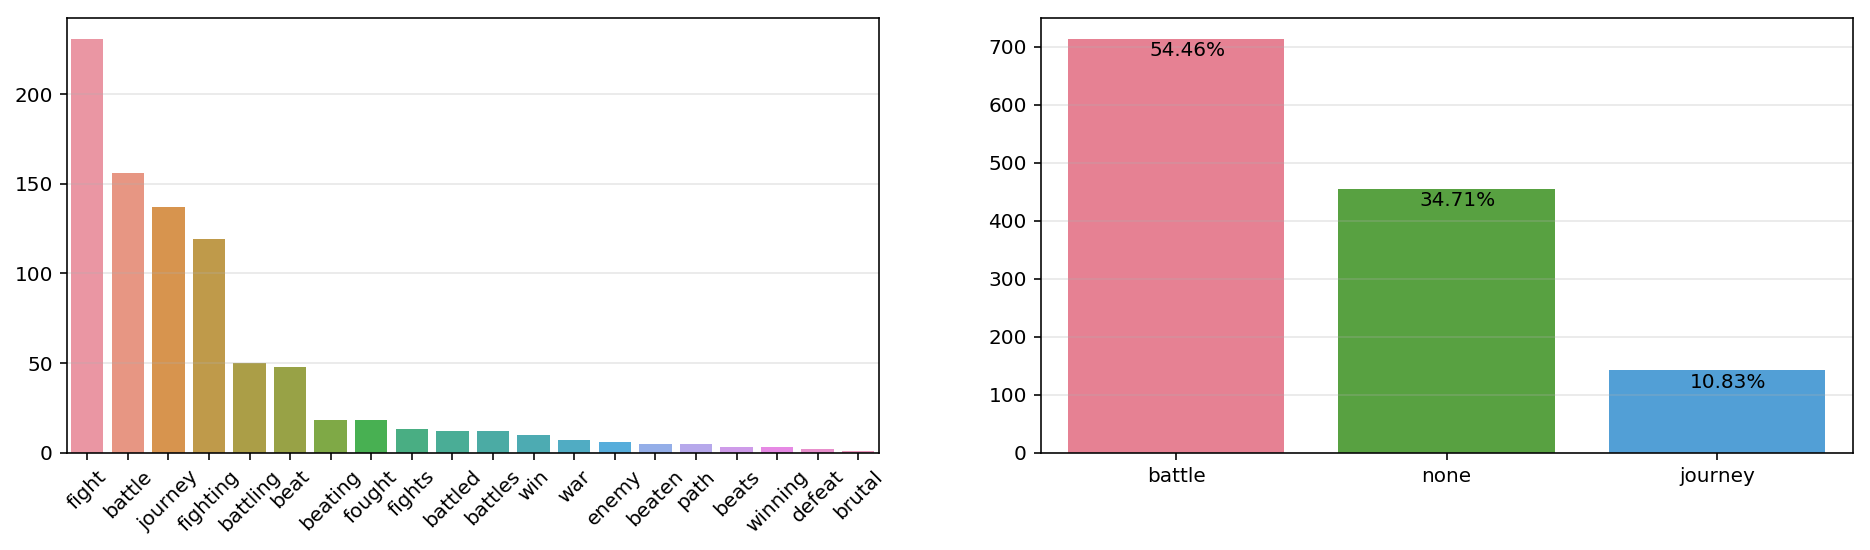

In [16]:
print(f'Total metaphor examples: {len(labeled.loc[labeled["metaphorical"] == True])}')

plt.subplots(1, 2, figsize=(16,4))

plt.subplot(1,2,1)
vc = labeled.loc[labeled['metaphorical'] == True, 'keyword'].value_counts();
sns.barplot(vc.index, vc.values)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.subplot(1,2,2)
vc = labeled.loc[labeled['metaphorical'] != False, 'type'].value_counts()
g = sns.barplot(vc.index, vc.values, palette='husl')
plt.grid(axis='y', alpha=0.3)

s = sum(vc.values)
for p in g.patches:
    h = p.get_height()
    plt.text(p.get_x() + 0.3, h - 30, f'{h/s*100:.2f}%')

In [17]:
labeled.to_csv(op.join(DATA_PROCESSED, 'labeled.csv'), index=False)

### TODO

o is the campaign about raising money for research, product, book, diets, etc. journey as raising money

o add "fighter" as keyword

o cancer fighting the patient, not the other way around - bring in POS to figure out if cancer is a subject or object, "cancer can’t beat us", "battle scars"

o situational model, looking at prosidy in speech

o measure of distinct words in a campaign

o characterizing metaphors with types of projects

# Auto-Detection

In [132]:
def related_to_cancer(text):
    '''
    Does the given text contain cancer-related keywords?
    '''
    return 'cancer' in text or 'leukemia' in text or 'melanoma' in text or 'lymphoma' in text

def find_metaphors(text):
    if not isinstance(text, float):
            
        if related_to_cancer(text.lower()):
                        
            for kw_match in re.finditer(r'\W(fight|fights|fighting|fought)\W', text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                next_ = text[kw_match.start():kw_match.end()+50].split()
#                 if text[kw_match.end()-1:kw_match.end()] in ['-', '/', '_']

                if len(next_) > 1 and re.match(r'(pain|depression|club|fear|anxiety|stress)', next_[1]):
                    continue
                
                yield {'fragment': text[start:end],
                       'char_location': kw_match.start(), 
                       'type': 'battle', 
                       'keyword': kw_match[1]}
                
            for kw_match in re.finditer(r'\W(battle|battles|battling|battled|beat|beats|beaten|beating|brutal)\W', text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                
                if kw_match.start() > 10 and text[kw_match.start()-10:kw_match.start()].split()[-1] in ['in', 'into']:
                    continue
                
                yield {'fragment': text[start:end],
                        'char_location': kw_match.start(), 
                        'type': 'battle', 
                        'keyword': kw_match[1]}
                
            if 'character' not in text.lower() and 'hero' not in text.lower():
                for kw_match in re.finditer(r'\W(enemy)\W', text.lower()):
                    start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                    yield {'fragment': text[start:end],
                           'char_location': kw_match.start(), 
                           'type': 'battle', 
                           'keyword': 'enemy'}
                    
            for kw_match in re.finditer(r'\W(path|destination)\W', text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                yield {'fragment': text[start:end],
                        'char_location': kw_match.start(), 
                        'type': 'journey', 
                        'keyword': kw_match[1]}
                
        for kw_match in re.finditer(r'\W(journey)\W', text.lower()):
            start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
            prev_ = text[kw_match.start()-50:kw_match.end()].split()
            next_ = text[kw_match.start():kw_match.end()+50].split()

            if len(prev_) > 1 and ('will' in prev_):
                continue
                
            if len(next_) > 1 and (next_[1] in ['from', 'will', 'across'] or 'time' in next_):
                continue

            surround = text[kw_match.start()-50:kw_match.end()+50]
            if 'theatrical' in surround:
                continue

            yield {'fragment': text[start:end],
                   'char_location': kw_match.start(), 
                   'type': 'journey', 
                   'keyword': 'journey'}
        
        for kw_match in re.finditer(r'\W(war (with|against|on) cancer|cancer war)\W', text.lower()):
            start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() - 8 + window)
            yield {'fragment': text[start:end],
                   'char_location': kw_match.start(), 
                   'type': 'battle', 
                   'keyword': 'war'}
        

In [133]:
instances['prediction'] = False

i = 0

for ix, instance in instances.iterrows():
    for metaphor in find_metaphors(df.loc[df['id'] == instance['project_id'], 'text'].values[0]):
        if np.abs(metaphor['char_location'] - instance['char_location']) < 4:
            instances.iloc[ix, 6] = True
            i += 1
            break
            
i

396

In the following charts, we hope to have all blue and no orange, or more realistically, large blue bars and small orange bars for each keyword.

The charts are broken into two: one for true metaphorical usage of the keyword, one for non-metaphorical usage of the keyword. Note that the x-axes are different because not every keyword in one of those groups in is the other.

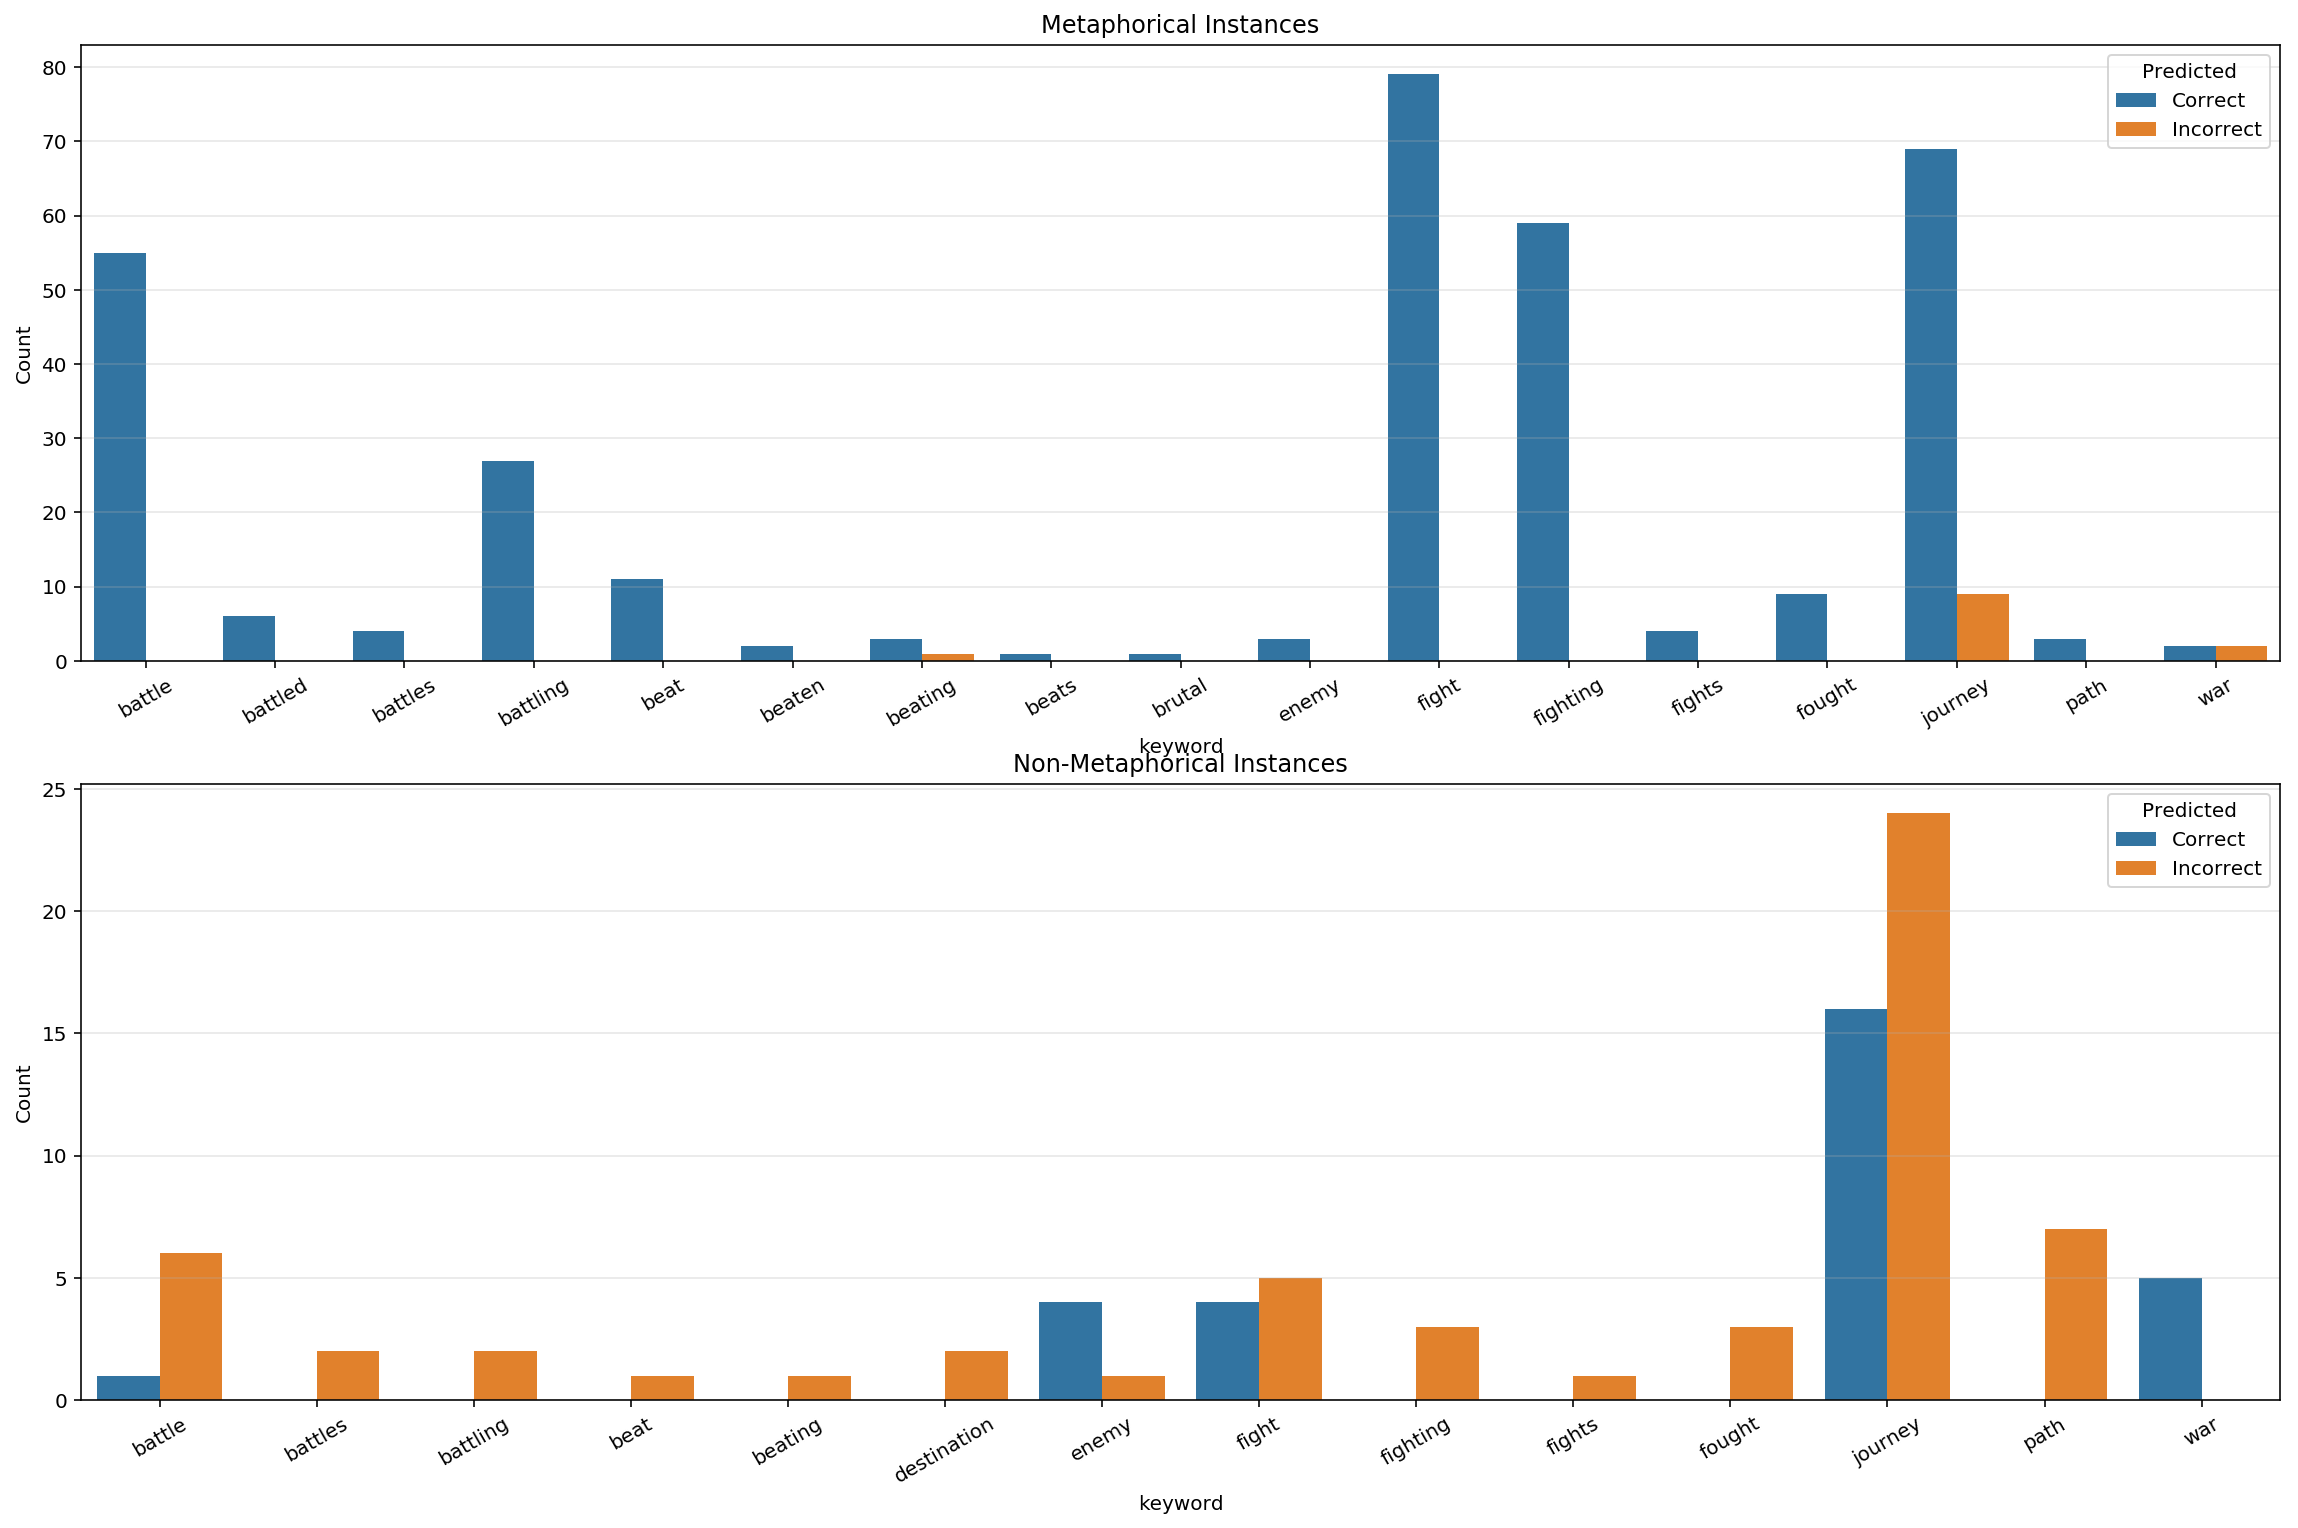

In [134]:
plt.subplots(figsize=(16,10))
plt.tight_layout()

plt.subplot(211)

g = instances.loc[instances['metaphorical'] == True].groupby('keyword').agg({'prediction': ['sum', 'count']})
s, c = g['prediction']['sum'], g['prediction']['count']

coll = pd.concat({'Correct': s, 'Incorrect': c - s}, axis=0).reset_index()

coll.rename(columns={'level_0': 'Predicted', 0: 'Count'}, inplace=True)

plt.grid(alpha=0.3, axis='y')
plt.title('Metaphorical Instances')
g = sns.barplot(y='Count', x='keyword', hue='Predicted', data=coll)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

plt.subplot(212)

g = instances.loc[instances['metaphorical'] == False].groupby('keyword').agg({'prediction': ['sum', 'count']})
s, c = g['prediction']['sum'], g['prediction']['count']

coll = pd.concat({'Correct': c - s, 'Incorrect': s}, axis=0).reset_index()

coll.rename(columns={'level_0': 'Predicted', 0: 'Count'}, inplace=True)

plt.grid(alpha=0.3, axis='y')
plt.title('Non-Metaphorical Instances')
g = sns.barplot(y='Count', x='keyword', hue='Predicted', data=coll)
g.set_xticklabels(g.get_xticklabels(), rotation=30);

Other forms of basically the same output

In [99]:
scores = []

vc = instances['keyword'].value_counts()

for ix, kw in instances.groupby('keyword'):
    scores.append({'keyword': ix, 'score': precision_score(kw['metaphorical'], kw['prediction']), 
                   'metric': 'precision', 'c': vc[vc.index == ix].values[0]})
    scores.append({'keyword': ix, 'score': recall_score(kw['metaphorical'], kw['prediction']), 
                   'metric': 'recall', 'c': vc[vc.index == ix].values[0]})
    
scores = pd.DataFrame(scores).sort_values(by='c', ascending=False)

/Users/alex/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


/Users/alex/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


metric
precision    0.799563
recall       0.896368
Name: score, dtype: float64

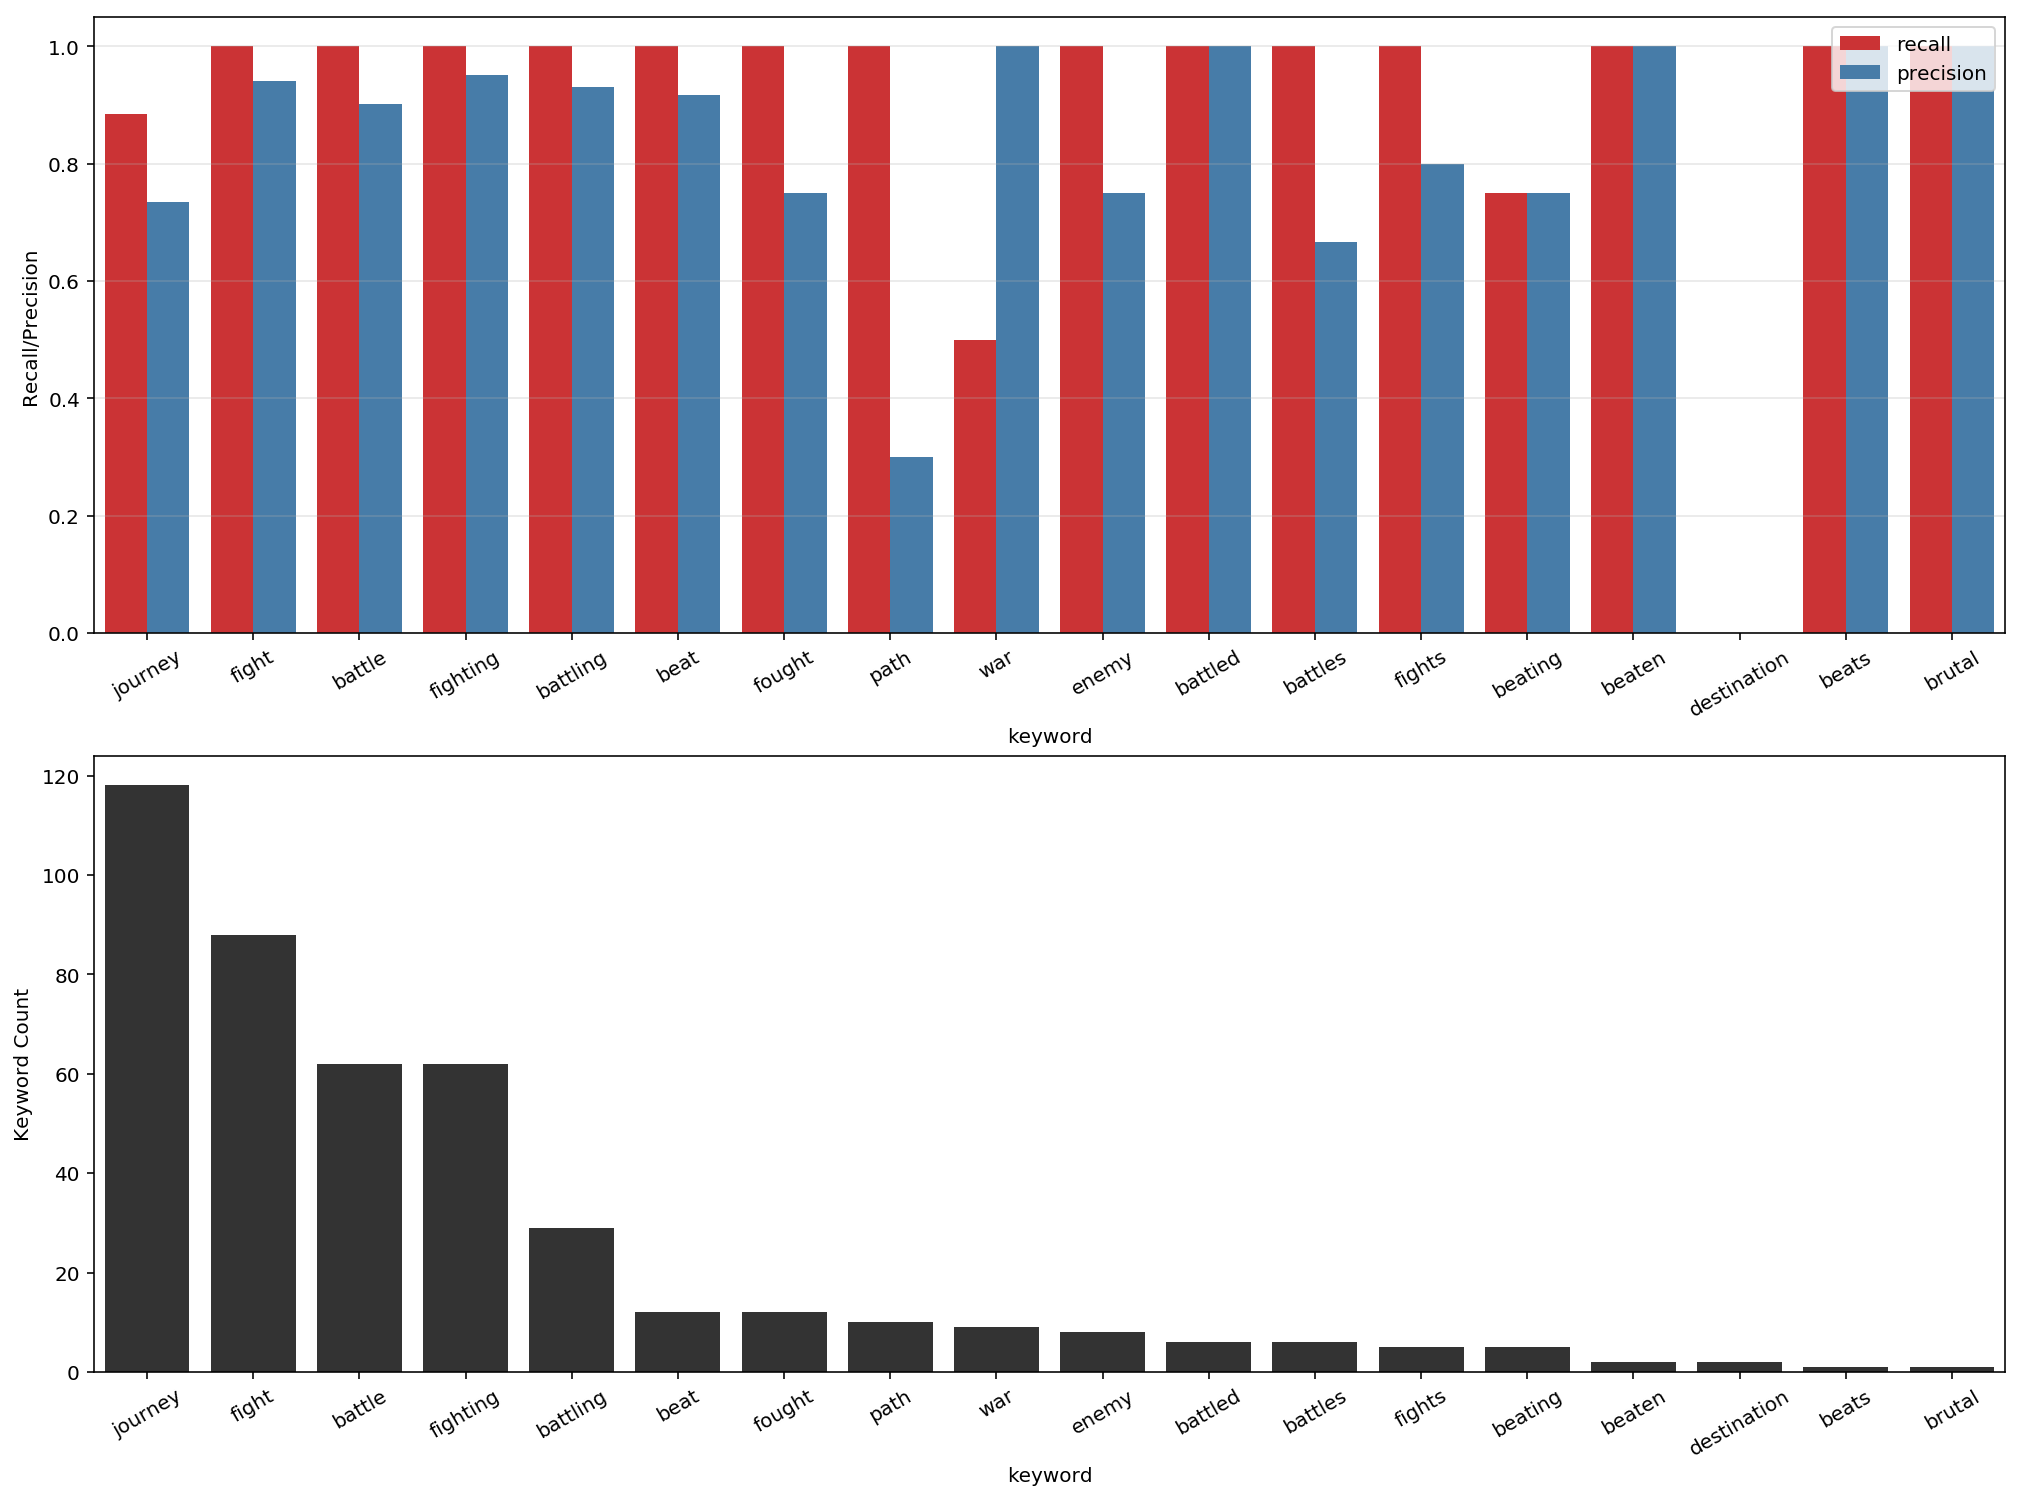

In [100]:
plt.subplots(figsize=(14,10))
plt.tight_layout()

plt.subplot(211)

g = sns.barplot(x='keyword', y='score', data=scores, hue='metric', palette='Set1')
plt.grid(alpha=0.3, axis='y')
plt.legend(loc='upper right')
g.set_xticklabels(g.get_xticklabels(), rotation=30)
g.set_ylabel('Recall/Precision');

plt.subplot(212)

g = sns.barplot(x='keyword', y='c', data=scores, color='#333333')
g.set_xticklabels(g.get_xticklabels(), rotation=30)
g.set_ylabel('Keyword Count')

scores.groupby('metric')['score'].mean()

# Neural Net Detection

In [18]:
from tqdm import tqdm_notebook as tqdm

from allennlp.commands.elmo import ElmoEmbedder

from nltk.tokenize import RegexpTokenizer

/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/allennlp/commands/find_learning_rate.py:42: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/alex/anaconda3/envs/nlp/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/alex/anaconda3/envs/nlp/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/alex/anaconda3/envs/nlp/lib/py

In [19]:
elmo = ElmoEmbedder()
tokenizer = RegexpTokenizer(r'\w+')

In [20]:
def pad(s, kw_start, lim=20):
    '''
    Limit a fragment to `lim` tokens. If less than, pad with empty strings.
    '''
    
    prior = tokenizer.tokenize(s[:kw_start])
    post = tokenizer.tokenize(s[kw_start:])
    
    if len(prior) < lim/2:
        while len(prior) < lim/2:
            prior.insert(0, '')
    else:
        prior = prior[len(prior) - round(lim/2):]
        
    if len(post) < lim/2:
        while len(post) < lim/2:
            post.append('')
    else:
        post = post[:round(lim/2)]
        
    prior.extend(post)
    return prior

In [21]:
tokens = 20

fragments = [pad(fragment.fragment, int(fragment.kw_start), tokens) for fragment in labeled[['fragment', 'kw_start']].dropna().itertuples()]

In [22]:
embds = elmo.embed_sentences(fragments)
embedded_fragments = np.array([embd[2] for embd in tqdm(embds)])

In [23]:
embedded_fragments.shape

(1104, 20, 1024)

In [24]:
y_data = labeled['metaphorical'].dropna().astype(int).values

In [30]:
from keras import backend as K
from keras.layers import *
from keras.models import Model
from keras import optimizers

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from sklearn import metrics

In [26]:
X_train, X_test, y_train, y_test = train_test_split(embedded_fragments, y_data, train_size=0.8, stratify=y_data)

/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [27]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    
    return 2*((p*r)/(p+r+K.epsilon()))

In [31]:
def build_model(input_tokens):

    inputs = Input(shape=(20, 1024), name="input")

    x = Bidirectional(GRU(20, return_sequences=True, name="gru"))(inputs)
    x = Dropout(0.3)(x)
    x = Bidirectional(GRU(20, name='gru2'))(x)

    x = Dropout(0.1)(x)
    x = Dense(20, activation='relu', name="dense")(x)
        
    predictions = Dense(2, activation='softmax', name="out")(x)
    _model = Model(inputs=inputs, outputs=predictions)

    _model.compile(optimizer=optimizers.Adam(lr=0.5*1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=[f1])
    
    return _model

In [32]:
model = build_model(tokens)
        
model.fit(X_train, y_train, epochs=20, class_weight={0: 50.0, 1: 1.0}, verbose=1)

p = model.predict(X_test)

Epoch 1/20
883/883 [==============================] - 4s 5ms/step - loss: 3.8351 - f1: 0.8712
Epoch 2/20
883/883 [==============================] - 2s 2ms/step - loss: 2.7826 - f1: 0.8712
Epoch 3/20
883/883 [==============================] - 2s 2ms/step - loss: 2.6088 - f1: 0.8718
Epoch 4/20
883/883 [==============================] - 2s 2ms/step - loss: 2.4042 - f1: 0.8715
Epoch 5/20
883/883 [==============================] - 2s 2ms/step - loss: 2.0163 - f1: 0.8721
Epoch 6/20
883/883 [==============================] - 2s 3ms/step - loss: 1.7696 - f1: 0.8714
Epoch 7/20
883/883 [==============================] - 3s 4ms/step - loss: 1.3629 - f1: 0.8719
Epoch 8/20
883/883 [==============================] - 3s 3ms/step - loss: 0.9838 - f1: 0.8717
Epoch 9/20
883/883 [==============================] - 2s 2ms/step - loss: 0.6877 - f1: 0.8710
Epoch 10/20
883/883 [==============================] - 2s 2ms/step - loss: 0.4304 - f1: 0.8718
Epoch 11/20
883/883 [==============================] - 2s 2

In [33]:
pd.crosstab(y_test, p.argmax(axis=1), rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,32,18,50
1,21,150,171
All,53,168,221


### Predict on unseen data

In [34]:
# tokens = 20

# fragments = [pad(fragment.fragment, int(fragment.kw_start), tokens) for fragment in labeled[['fragment', 'kw_start']].dropna().itertuples()]

def embed_fragment(fragment, start, tokens):
    tokens = pad(fragment, start, tokens)
    return elmo.embed_sentence(tokens)[2]

In [90]:
c = int(input(f'N (max: {int(max_unlabeled()):,}): '))

tp, fp, nan = 0, 0, 0
        
for project in all_projects.sample(frac=1).itertuples():
    
    print()
    print(f'PROJECT {project.name}')
    
    keyword_found = False
    
    for source, key in [(BATTLE_WORDS, 'battle'), (JOURNEY_WORDS, 'journey')]:
        for prompt, result in find_keywords(project.text, source, key):
            
            if exists_with_keyword(labeled, project.id, result['char_location']):
                continue
            
            if exists_without_keywords(labeled, project.id):
                labeled = labeled.loc[labeled['project_id'] != project.id]
            
            keyword_found = True
            print(prompt)
            result['project_id'] = project.id
            
            embedding = embed_fragment(result['fragment'], int(result['kw_start']), tokens)
            prediction = model.predict(np.array([embedding]))
                
            # only present if low confidence
#             if prediction[0].max() < confidence_threshold:
            print(f'Non-Metaphorical: {prediction[0][0]:.3f}\t Metaphorical: {prediction[0][1]:.3f}')
            
            if is_metaphorical():
                result['metaphorical'] = True
                labeled = labeled.append(result, ignore_index=True)                
                tp += 1
            else:
                result['metaphorical'] = False
                labeled = labeled.append(result, ignore_index=True)
                fp += 1
                
    if keyword_found:
        c -= 1
        
    # if no metaphor existed and this isn't already known
    if not keyword_found and not exists_without_keywords(labeled, project.id):
        result = {'project_id': project.id,
                    'fragment': np.nan, 
                    'char_location': np.nan,
                    'kw_start': np.nan,
                    'type': 'none',
                    'metaphorical': np.nan,
                    'keyword': np.nan}
        
        labeled = labeled.append(result, ignore_index=True)  
        nan += 1
        print('No metaphors found')
    
    if c <= 0:
        break

print(f'True Positives: {tp} - False Positives: {fp} - Non-existent: {nan}')

N (max: 1,240): 5

PROJECT Bob Cawley Sr. Cancer Battle
ou know my father than you already know that the last 4 years he has been in the fight of his life, we were told 2 weeks ago that he no longer has any options other th
Non-Metaphorical: 0.005	 Metaphorical: 0.995
Is this a cancer related metaphor? y
ur family is asking for any help on behalf of my father so that we can keep this FIGHT going!! God Bless
Non-Metaphorical: 0.005	 Metaphorical: 0.995
Is this a cancer related metaphor? y

PROJECT Living Art: 15 Paintings on Living through Cancer
No metaphors found

PROJECT HELP Detlev Hanschke Fight Cancer
a strong presence in our community. Every contribution makes a difference in the fight.  All funds will be used to directly benefit in Detlev’s survival. Prayers and p
Non-Metaphorical: 0.002	 Metaphorical: 0.998
Is this a cancer related metaphor? y
ious stage and is very much threatening his life. After much effort in trying to beat this alone, it’s time for us to reach out to all o

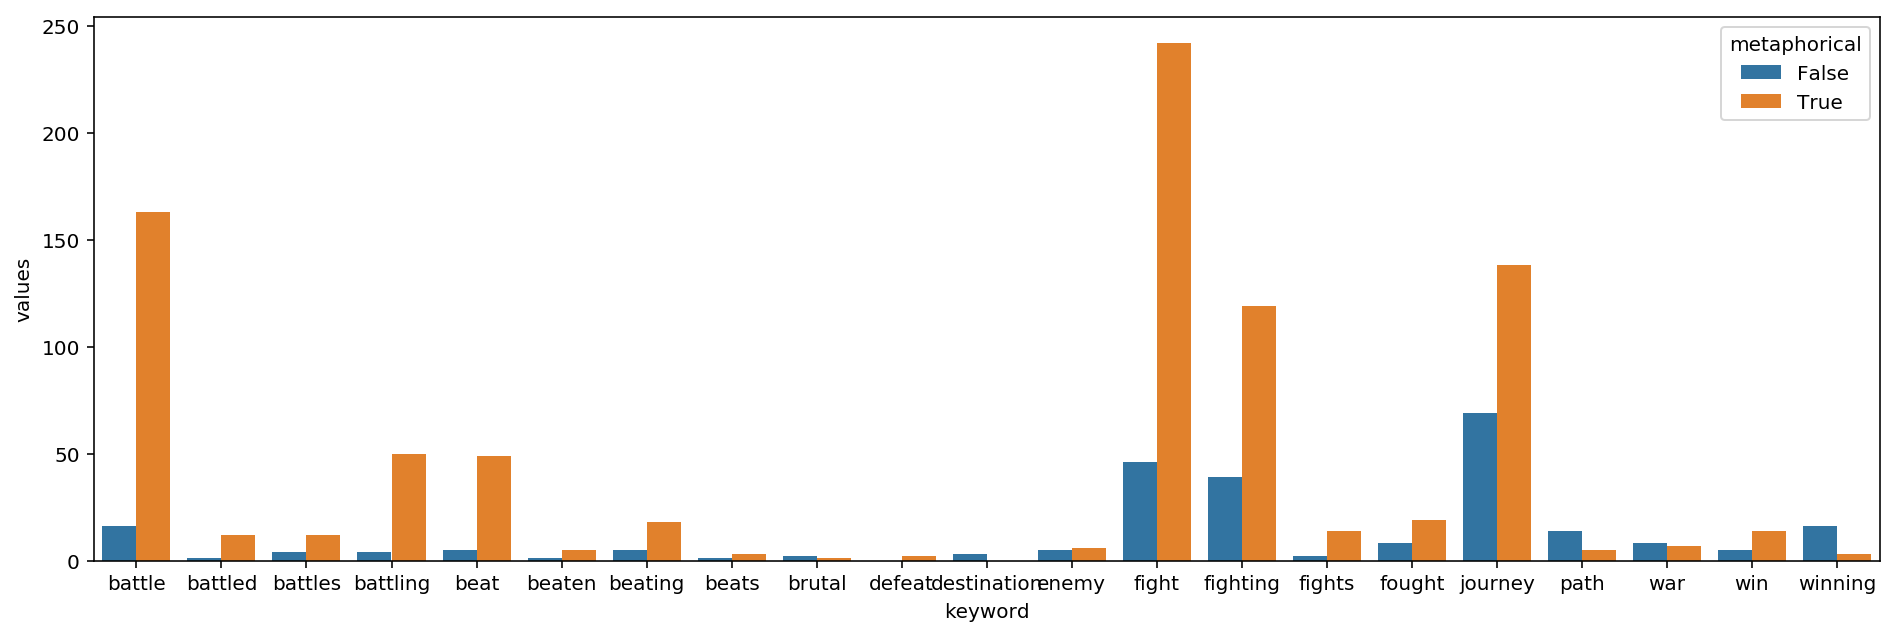

In [73]:
vc = labeled.loc[labeled['metaphorical'].notnull()].groupby('keyword')['metaphorical'].value_counts()

plt.subplots(figsize=(16,5))
vc = vc.unstack().fillna(0).stack().reset_index()
vc = vc.rename({0: 'count'}, axis=1)
sns.barplot('keyword', y='count', data=vc, hue='metaphorical')